In [1]:
from simtk import openmm, unit
from simtk.openmm import app
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# System properties

- 1 particle
- Mass

In [2]:
mass = 100.0 * unit.amu

In [3]:
system = openmm.System()

In [4]:
system.addParticle(mass)

0

In [5]:
force = openmm.CustomExternalForce('A*x^4+B*x^2+C*x + D*(y^2+z^2)')

In [6]:
Eo=4.0 * unit.kilocalories_per_mole
a=1.0 * unit.nanometers
b=0.0 * unit.kilocalories_per_mole

k = 8.0*Eo/(a**2) # stiffness of the armonic potential for coordinates Y and Z

A = Eo/(a**4)
B = -2.0*Eo/(a**2)
C = -b/a
D = k/2.0

In [7]:
force.addGlobalParameter('A', A)
force.addGlobalParameter('B', B)
force.addGlobalParameter('C', C)
force.addGlobalParameter('D', D)

3

In [8]:
force.addParticle(0)

0

In [9]:
system.addForce(force)

0

In [10]:
temperature = 300.0*unit.kelvin
friction = 0.5/unit.picoseconds
integration_timestep = 0.02 * unit.picoseconds

In [11]:
integrator = openmm.LangevinIntegrator(temperature, friction, integration_timestep)

In [12]:
platform = openmm.Platform.getPlatformByName('CUDA')

In [13]:
context = openmm.Context(system, integrator, platform)

In [14]:
initial_positions =  np.zeros([1, 3], np.float32) * unit.nanometers
initial_velocities = np.zeros([1, 3], np.float32) * unit.nanometers/unit.picoseconds

In [15]:
initial_positions

Quantity(value=array([[0., 0., 0.]], dtype=float32), unit=nanometer)

In [16]:
initial_positions[0,0]=1.0*unit.nanometer

In [17]:
context.setPositions(initial_positions)

In [18]:
context.setVelocities(initial_velocities)

In [19]:
saving_time = 1.0 * unit.picoseconds
saving_steps = int(saving_time/integration_timestep)

simulation_time = 20 * unit.nanoseconds
simulation_steps = int(simulation_time/integration_timestep)
n_saving_periods = int(simulation_steps/saving_steps)

print('Integration timestep:', integration_timestep)
print('Number of steps in saving period:', saving_steps)
print('Number of saving periods:', n_saving_periods)

Integration timestep: 0.02 ps
Number of steps in saving period: 50
Number of saving periods: 20000


In [20]:
n_frames = n_saving_periods + 1
trajectory =  np.zeros([n_frames, 1, 3], np.float32) * unit.nanometers
time = np.zeros([n_frames], np.float32) * unit.nanoseconds

In [21]:
trajectory[0, :, :] = initial_positions
time[0]= 0 * unit.picoseconds

In [22]:
for ii in range(n_saving_periods):
    integrator.step(saving_steps)
    state = context.getState(getPositions=True)
    trajectory[ii+1, :, :] = state.getPositions()
    time[ii+1]=state.getTime()

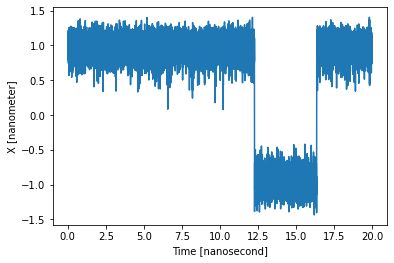

In [23]:
plt.plot(time, trajectory[:, 0, 0])
plt.xlabel('Time [{}]'.format(time.unit))
plt.ylabel('X [{}]'.format(trajectory.unit))
plt.show()

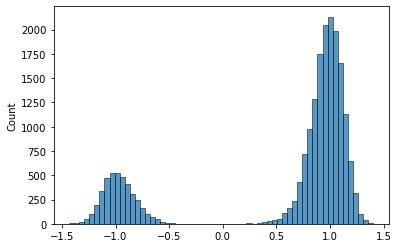

In [24]:
sns.histplot(trajectory[:,0,0], bins=60)
plt.show()

In [25]:
in_left = trajectory[:, 0, 0] < 0.0*unit.nanometers
in_right = trajectory[:, 0, 0] >= 0.0*unit.nanometers
n_left=in_left.sum()
n_right=in_right.sum()

print('Left occupation:', n_left)
print('Right occupation:', n_right)

Left occupation: 4088
Right occupation: 15913


In [26]:
P_left = n_left/n_frames
P_right = n_right/n_frames

print('Left probability:', P_left)
print('Right probability:', P_right)

Left probability: 0.20438978051097445
Right probability: 0.7956102194890255


https://seaborn.pydata.org/tutorial/distributions.html#tutorial-hist